In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

In [3]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"
DATES = pd.Series(['20230409', '20230410'])
# DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230409'

# TOOLS

## SAIL Data

In [4]:
class FastData(object):
    data = None

class FastDataSAIL(FastData):
    @staticmethod
    def open_raw(files):
        files = sorted(files)
        high_rate_dfs = []
        for file in files:
            # Regular expression. extract date
            date = re.search(r"gucecorM1\.00\.(\d+)\.", file).group(1)
            df = pd.read_csv(file, skiprows=1, header=None).rename(
                    columns = dict(
                        zip(range(0,10), 
                        [
                            'Timestamp',
                            'u',
                            'v',
                            'w',
                            'windspeed units (M = m/s)',
                            'Speed of Sound',
                            'Status (00 means okay)',
                            'CO2 analog voltage output',
                            'H20 analog voltage output',
                            'Checksum',
                        ])
                    )
                )
            df['time'] = pd.to_datetime(
                f'{date} ' + df['Timestamp'].str[:-3],
                format="%Y%m%d %H:%M:%S.%f"
            )
            high_rate_dfs.append(df)
        return pd.concat(high_rate_dfs).set_index('time')
    
    @staticmethod
    def double_rotation(df, u_col, v_col, w_col):
        # FIRST ROTATION
        mean_u = df[u_col].mean()
        mean_v = df[v_col].mean()
        theta = np.arctan2(mean_v, mean_u)
        adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
        adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
        df[u_col] = adj_u
        df[v_col] = adj_v
        print(
            'Means after 1st rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )

        # SECOND ROTATION
        mean_u = df[u_col].mean()
        mean_w = df[w_col].mean()
        phi = np.arctan2(mean_w, mean_u)
        adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
        adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
        df[u_col] = adj_u
        df[w_col] = adj_w
        print(
            'Means after 2nd rotation:',
            df[u_col].mean(),
            df[v_col].mean(),
            df[w_col].mean(),
        )
        return df

# SAIL EC data

Open and wrangle the raw SAIL EC data

In [5]:
fast_data_files = DATES.apply(
    lambda date: glob.glob(
            os.path.join(
                DATA_DIR, 
                f"sail_fast_ecor_data/gucecorM1.00.{date}.000000.raw/**_sonic.raw"
            )
        )
).explode()
fast_data_files

0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
0    /Users/elischwat/Development/data/sublimationo...
                           ...                        
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
1    /Users/elischwat/Development/data/sublimationo...
Length: 96, dtype: object

In [6]:
fast_df_sail = FastDataSAIL.open_raw(fast_data_files)
fast_df_sail = utils.modify_df_timezone(fast_df_sail.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_sail = fast_df_sail.loc[DATE_LOCAL]
fast_df_sail = fast_df_sail.sort_index()

Calculate 30-minute mean u, v, w, and 30-min wind direction, plot it

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

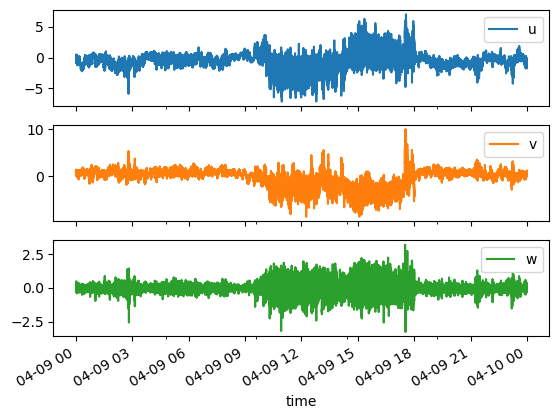

In [7]:
fast_df_sail[['u','v','w']].plot(subplots=True)

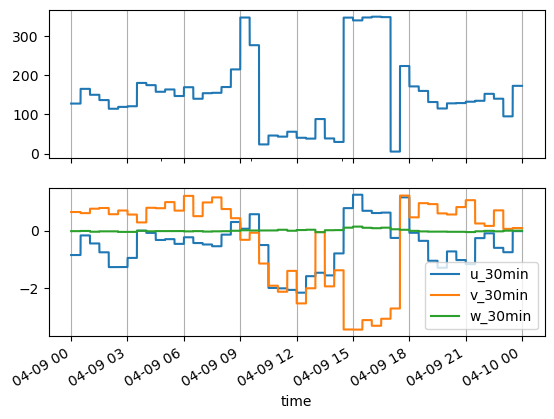

In [8]:
fast_df_sail = fast_df_sail.join(
    fast_df_sail.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sail['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sail['u_30min'], -fast_df_sail['v_30min']))
fast_df_sail['dir_30min'] = fast_df_sail['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)
fig, axes = plt.subplots(2,1)
fast_df_sail['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sail[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [ ]:
fast_df_sail = fast_df_sail.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

In [ ]:
fast_df_sail.index = fast_df_sail.index.get_level_values(1)

In [ ]:
fast_df_sail['u'] = fast_df_sail['u'].interpolate()
fast_df_sail['v'] = fast_df_sail['v'].interpolate()
fast_df_sail['w'] = fast_df_sail['w'].interpolate()

Calculate MRD

In [ ]:
mrd_uw_sail = fast_df_sail.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

In [ ]:
mrd_uw_sail.hour_group = mrd_uw_sail.hour_group.str.replace('2023-04-18 ', '')

In [ ]:
alt.Chart(mrd_uw_sail.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

In [ ]:
mrd_uw_sail['time range'] = mrd_uw_sail.start_time.astype(str) + ' - ' + mrd_uw_sail.end_time.astype(str)

In [ ]:
alt.Chart(mrd_uw_sail.reset_index()).mark_line(strokeWidth=1).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Color('hour_group:O').scale(scheme='rainbow'),
    detail = 'time range'
).properties(width=300, height=300)

# SPLASH EC data

In [17]:
splash_files = np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "asfs/ASFS-50_Level2_SPLASH2021-2023/sledwind10hz.asfs50.level2.0.*.nc")
    ) if d in f]
    for d in DATES
]).flatten()
fast_df_splash = xr.open_mfdataset(splash_files).to_dataframe().rename(columns={
    'metek_u': 'u',
    'metek_v': 'v',
    'metek_w': 'w',
})

In [ ]:
fast_df_splash = utils.modify_df_timezone(fast_df_splash.reset_index(), 'UTC', 'US/Mountain').set_index('time')
fast_df_splash = fast_df_splash.loc[DATE_LOCAL]

In [ ]:
fast_df_splash = fast_df_splash.join(
    fast_df_splash.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_splash['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_splash['u_30min'], -fast_df_splash['v_30min']))
fast_df_splash['dir_30min'] = fast_df_splash['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

In [ ]:
fast_df_splash_30min = fast_df_splash.groupby(pd.Grouper(freq='30min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_splash_30min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_splash_30min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [ ]:
fast_df_splash = fast_df_splash.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

In [ ]:
fast_df_splash.index = fast_df_splash.index.get_level_values(1)

In [ ]:
fast_df_splash['u'] = fast_df_splash['u'].interpolate()
fast_df_splash['v'] = fast_df_splash['v'].interpolate()
fast_df_splash['w'] = fast_df_splash['w'].interpolate()

Calculate MRD

In [ ]:
mrd_uw_splash = fast_df_splash.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

In [ ]:
mrd_uw_splash.hour_group = mrd_uw_splash.hour_group.str.replace('2023-04-18 ', '')

In [ ]:
alt.Chart(mrd_uw_splash.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)

# SOS EC data

Open data, average from 20hz to 10hz

In [ ]:
fast_df_sos = fast_data_files_to_dataframe(glob.glob(
                os.path.join(DATA_DIR, 'sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230409_**.nc')
        ), 
        rotation='none'
)

In [ ]:
fast_df_sos = fast_df_sos.set_index('time').loc['20230409']

In [ ]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='100ms')).mean()

In [ ]:
fast_df_sos = fast_df_sos[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
    'u_3m_c': 'u',
    'v_3m_c': 'v',
    'w_3m_c': 'w',
})

In [ ]:
fast_df_sos = fast_df_sos.join(
    fast_df_sos.groupby(pd.Grouper(freq='30min'))[['u', 'v', 'w']].transform('mean').rename(columns = {
        'u': 'u_30min',
        'v': 'v_30min',
        'w': 'w_30min',
    })
)
fast_df_sos['dir_30min'] = np.rad2deg(np.arctan2(-fast_df_sos['u_30min'], -fast_df_sos['v_30min']))
fast_df_sos['dir_30min'] = fast_df_sos['dir_30min'].apply(lambda dir: dir if dir >= 0 else dir+360)

In [ ]:
fast_df_sos_30min = fast_df_sos.groupby(pd.Grouper(freq='30min')).mean()
fig, axes = plt.subplots(2,1)
fast_df_sos_30min['dir_30min'].plot(ax=axes[0], sharex=True)
fast_df_sos_30min[['u_30min','v_30min','w_30min']].plot(ax=axes[1])
axes[0].grid(axis='x')  # Add grid lines only for the x-axis
axes[1].grid(axis='x')  # Add grid lines only for the x-axis
plt.show()

Apply double rotation to 3hr chunks

In [ ]:
fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='180min')).apply(lambda df: FastDataSAIL.double_rotation(df, 'u', 'v', 'w'))

In [ ]:
fast_df_sos.index = fast_df_sos.index.get_level_values(1)

In [ ]:
fast_df_sos['u'] = fast_df_sos['u'].interpolate()
fast_df_sos['v'] = fast_df_sos['v'].interpolate()
fast_df_sos['w'] = fast_df_sos['w'].interpolate()

Calculate MRD

In [ ]:
mrd_uw_sos = fast_df_sos.groupby(pd.Grouper(freq='180min'))[['u', 'v', 'w']].apply(
    lambda df: calculate_mrd_for_df(df.reset_index(), 'u', 'w', shift=2000, parallelism=20).assign(hour_group = f"{df.index.min()} - {df.index.max()}")
)

In [ ]:
mrd_uw_sos.hour_group = mrd_uw_sos.hour_group.str.replace('2023-04-09 ', '')

In [ ]:
alt.Chart(mrd_uw_sos.reset_index()).mark_boxplot(size=10, outliers=False).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('Co:Q'),
    alt.Column('hour_group'),
).properties(width=200, height=200)